# Hate Speech Detection using Deep Learning

**Ain Shams University - Faculty of Engineering**  
**CSE485 Deep Learning: Major Task**

---

## Project Overview

This project implements a Deep Learning model to detect hate speech in tweets using LSTM (Long Short-Term Memory) networks. The dataset contains tweets classified into three categories:

- **0 - Hate Speech**: Content explicitly targeting individuals or groups with harmful intent
- **1 - Offensive Language**: Content containing offensive language but not necessarily hate speech  
- **2 - Neither**: Neutral content without any offensive or hateful intent

## Objectives

1. Explore and visualize the dataset
2. Preprocess textual data (stopwords, punctuation removal, lemmatization)
3. Build and train an LSTM model
4. Evaluate model performance
5. Analyze results comprehensively

In [ ]:
# Google Drive download (Colab only)
!pip install gdown -q

#1.Imports

In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import re
import string
import gdown

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Machine Learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.utils import class_weight

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

# Warnings
import warnings
warnings.filterwarnings('ignore')

from collections import Counter

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# 2.Load and Explore Dataset


In [ ]:

# Download from Google Drive
file_id = '1tn2X9JtOjqG7PKTZLUEy8sJS0r_WV7Qf'
url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(url, 'hate_speech.csv', quiet=False)

# Load dataset
df = pd.read_csv('hate_speech.csv')
print(f"Shape: {df.shape}")
print(df['class'].value_counts().sort_index())
df.head()

Downloading...
From: https://drive.google.com/uc?id=1tn2X9JtOjqG7PKTZLUEy8sJS0r_WV7Qf
To: /content/hate_speech.csv
100%|██████████| 2.21M/2.21M [00:00<00:00, 190MB/s]

Shape: (24783, 2)
class
0     1430
1    19190
2     4163
Name: count, dtype: int64


,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


##2.1 Basic dataset information

In [ ]:

print("Dataset Information:")
print(df.info())

print("\nDuplicate Rows:")
print(f"Number of duplicate rows: {df.duplicated().sum()}")


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB
None

Duplicate Rows:
Number of duplicate rows: 0


#3.Data Visualization and Class Distribution

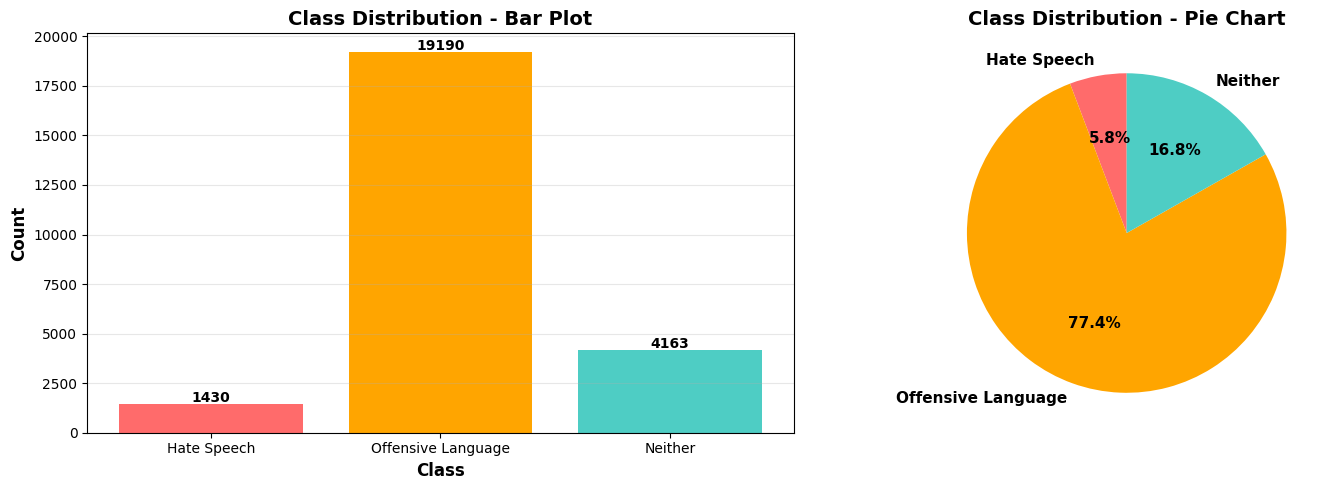

In [ ]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

class_counts = df['class'].value_counts().sort_index()
# Create labels for classes
class_labels = {
    0: 'Hate Speech',
    1: 'Offensive Language',
    2: 'Neither'
}
class_counts_labeled = class_counts.rename(class_labels)

# Bar plot
axes[0].bar(class_counts_labeled.index, class_counts_labeled.values, color=['#FF6B6B', '#FFA500', '#4ECDC4'])
axes[0].set_xlabel('Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Class Distribution - Bar Plot', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts_labeled.values):
    axes[0].text(i, v + 100, str(v), ha='center', fontweight='bold')

# Pie chart
colors = ['#FF6B6B', '#FFA500', '#4ECDC4']
axes[1].pie(class_counts.values, labels=[class_labels[i] for i in class_counts.index],
            autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Class Distribution - Pie Chart', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Key Findings: Class Distribution

**Critical Observations:**
1. **Severe Class Imbalance Detected:**
   - Offensive Language dominates with **77.4%** (19,190 tweets)
   - Neither class: **16.8%** (4,163 tweets)
   - Hate Speech is severely underrepresented: **5.8%** (1,430 tweets)

2. **Imbalance Ratio:** The largest class (Offensive) is **13.4x larger** than the smallest (Hate Speech)

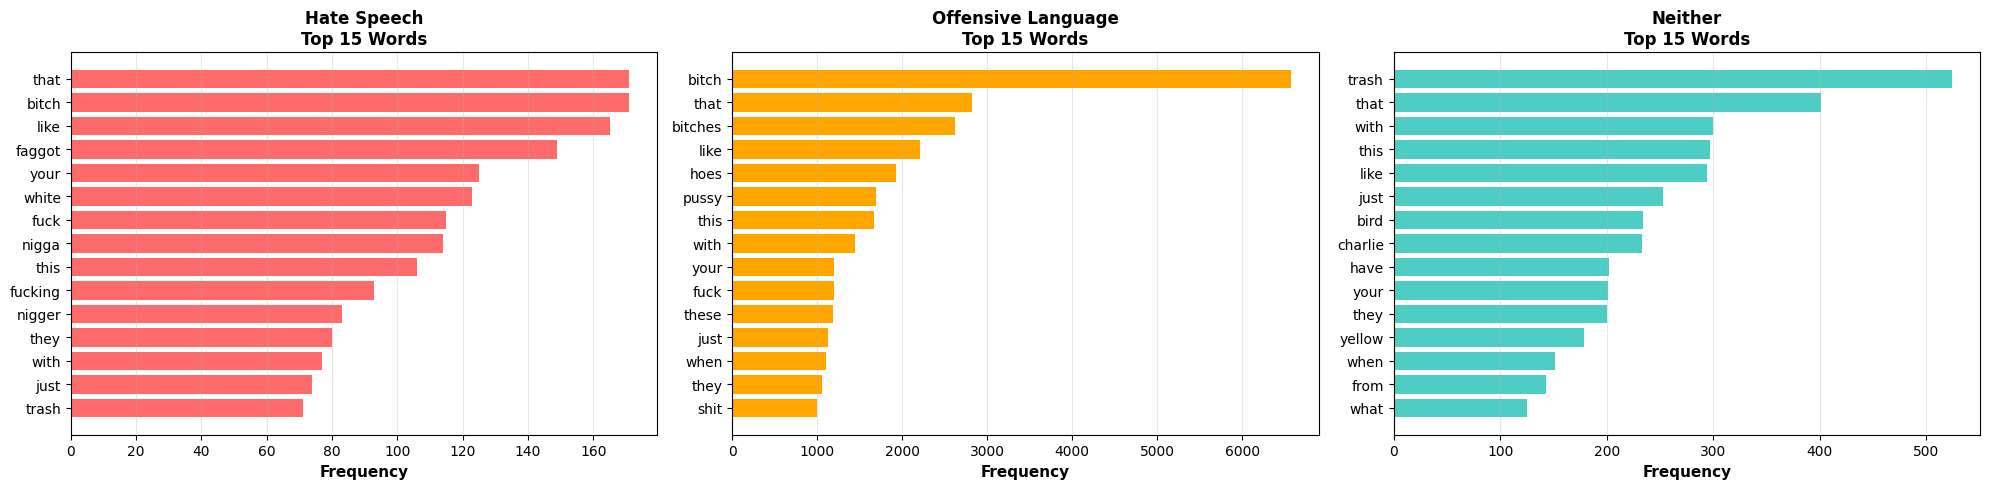

In [ ]:
# Visualize word frequencies by class
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for idx, cls in enumerate(sorted(df['class'].unique())):
    # Get all tweets for this class
    tweets_in_class = df[df['class'] == cls]['tweet'].astype(str)

    # Combine all words
    all_words = ' '.join(tweets_in_class).lower().split()

    # Count word frequencies (excluding very short words and common symbols)
    word_freq = Counter([word for word in all_words if len(word) > 3 and word.isalpha()])

    # Get top 15 most common words
    top_words = dict(word_freq.most_common(15))

    # Create bar plot
    words = list(top_words.keys())
    freqs = list(top_words.values())

    axes[idx].barh(words, freqs, color=['#FF6B6B', '#FFA500', '#4ECDC4'][cls])
    axes[idx].set_xlabel('Frequency', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{class_labels[cls]}\nTop 15 Words', fontsize=12, fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

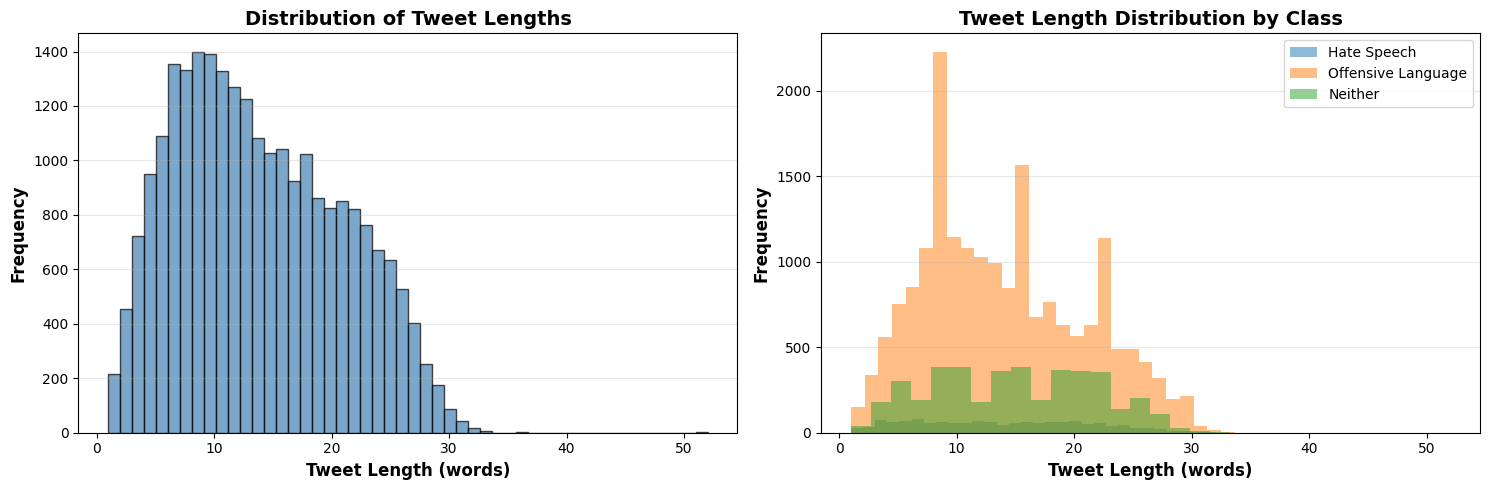


Average tweet length: 14.12 words
Median tweet length: 13.00 words
Max tweet length: 52 words
Min tweet length: 1 words


In [ ]:
# Analyze tweet lengths
df['tweet_length'] = df['tweet'].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall tweet length distribution
axes[0].hist(df['tweet_length'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Tweet Length (words)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Tweet Lengths', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Tweet length by class
for cls in sorted(df['class'].unique()):
    axes[1].hist(df[df['class'] == cls]['tweet_length'], bins=30, alpha=0.5, label=class_labels[cls])
axes[1].set_xlabel('Tweet Length (words)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Tweet Length Distribution by Class', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAverage tweet length: {df['tweet_length'].mean():.2f} words")
print(f"Median tweet length: {df['tweet_length'].median():.2f} words")
print(f"Max tweet length: {df['tweet_length'].max()} words")
print(f"Min tweet length: {df['tweet_length'].min()} words")

### Tokenization and Padding Decisions

The tweet length distribution indicates that most tweets are relatively short, with a median length of 13 words and only a small number of tweets exceeding 30 words.

Furthermore, the class-wise analysis shows that hate speech, offensive language, and neutral tweets have very similar length distributions. This confirms that tweet length alone is not a discriminative feature and that a single, unified padding strategy can be applied across all classes. Consequently, the model is encouraged to focus on semantic and contextual information rather than sequence length when performing classification.


# 4.Data Preprocessing

## 4.1 Data Imbalance

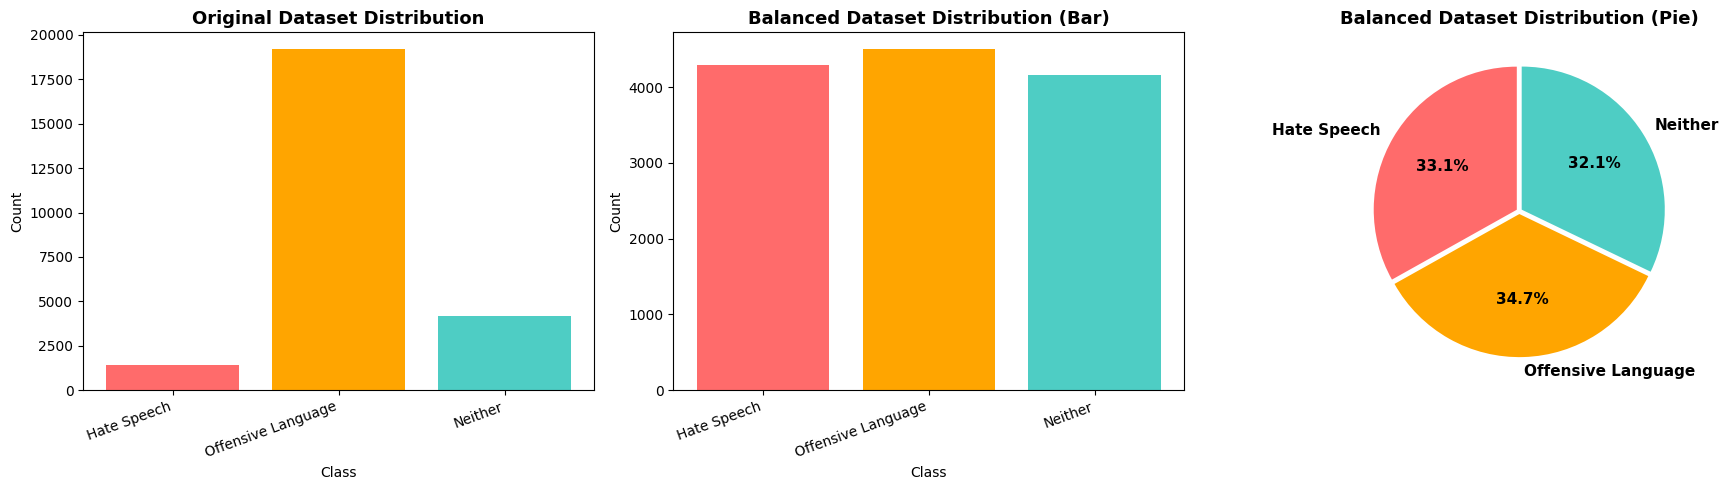

In [ ]:
class_0 = df[df['class'] == 0]  # Hate Speech
class_1 = df[df['class'] == 1].sample(n=4500, random_state=42)  # Offensive Language
class_2 = df[df['class'] == 2]  # Neutral

df_balanced = pd.concat([class_0, class_0, class_0, class_1, class_2], axis=0)

#plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# -----------------------------------
# 1 Bar chart BEFORE balancing
# -----------------------------------
original_counts = df['class'].value_counts().sort_index()

axes[0].bar(
    original_counts.index,
    original_counts.values,
    color=colors
)
axes[0].set_title('Original Dataset Distribution', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

axes[0].set_xticks(original_counts.index)
axes[0].set_xticklabels(
    [class_labels[i] for i in original_counts.index],
    rotation=20,
    ha='right'
)

# -----------------------------------
# 2 Bar chart AFTER balancing
# -----------------------------------
balanced_counts = df_balanced['class'].value_counts().sort_index()

axes[1].bar(
    balanced_counts.index,
    balanced_counts.values,
    color=colors
)
axes[1].set_title('Balanced Dataset Distribution (Bar)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

axes[1].set_xticks(balanced_counts.index)
axes[1].set_xticklabels(
    [class_labels[i] for i in balanced_counts.index],
    rotation=20,
    ha='right'
)

# -----------------------------------
# 3 Pie chart AFTER balancing
# -----------------------------------
axes[2].pie(
    balanced_counts.values,
    labels=[class_labels[i] for i in balanced_counts.index],
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    explode=(0.02, 0.02, 0.02),
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)
axes[2].set_title('Balanced Dataset Distribution (Pie)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()



## 4.2 text preprocessing

In [ ]:
import nltk

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:

# dataset shape to know how many tweets in the datasets
print(f"num of tweets: {df_balanced.shape}")

# extract the text and labels
tweet = list(df_balanced['tweet'])
labels = list(df_balanced['class'])


#notes : all of the function taking 1 text at a time
stop_words = set(stopwords.words('english'))

# add rt to remove retweet in dataset (noise)
stop_words.add("rt")

# remove html entity:
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# remove the user tags
def remove_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "", raw_text)

    return text

# remove urls
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)

    return text

# remove unnecessary symbols
def remove_noise_symbols(raw_text):
    text = re.sub(r'[^\w\s]', '', raw_text)  # Removes ALL punctuation
    return text

# remove stopwords
def remove_stopwords(raw_text):
    tokenize = nltk.word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = " ".join(text)

    return text

def lemmatization(raw_text):
  lemmatizer = WordNetLemmatizer()
  words = [lemmatizer.lemmatize(word) for word in raw_text.split() ]
  return " ".join(words)

## this function in to clean all the dataset by utilizing all the function above
def preprocess(datas):
    clean = []
    # remove the @xxx"
    clean = [remove_user(text) for text in datas]
    # remove emojis (specifically unicode emojis)
    clean = [remove_entity(text) for text in clean]
    # remove urls
    clean = [remove_url(text) for text in clean]
    # remove trailing stuff
    clean = [remove_noise_symbols(text) for text in clean]
    # remove stopwords
    clean = [remove_stopwords(text) for text in clean]

    clean = [lemmatization(text) for text in clean]

    return clean

# call the cleaning function
processed_tweet = preprocess(tweet)

processed_tweet[:5]


num of tweets: (12953, 3)


['queer gaywad',
 'alsarabsss he beaner smh tell he mexican',
 'youre fucking gay blacklisted hoe Holding TehGodClan anyway',
 'LMFAOOOO HATE BLACK PEOPLE there black people nigger',
 'least Im nigger Lmfao']

In [ ]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

processed_2 = df_balanced['tweet'].apply(preprocess_text)
processed_2[:5]

,tweet
85,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1..."
89,"""@CB_Baby24: @white_thunduh alsarabsss"" he bea..."
110,"""@DevilGrimz: @VigxRArts fucking gay, blacklis..."
184,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL..."
202,"""@NoChillPaz: ""At least I'm nigger"" http://t.c..."


#5.Tokenization and Padding

In [ ]:
# Coverage analysis for max_len =20, 25, 30, 35, 40
processed_lengths = [len(tweet.split()) for tweet in processed_tweet]

print("Coverage Analysis:\n")
for max_len_test in [20,25,30, 35, 40]:
    covered = sum(1 for l in processed_lengths if l <= max_len_test)
    coverage = covered / len(processed_lengths) * 100
    print(f"max_len = {max_len_test}  →  covers {coverage:.1f}% of tweets")

Coverage Analysis:

max_len = 20  →  covers 99.8% of tweets
max_len = 25  →  covers 100.0% of tweets
max_len = 30  →  covers 100.0% of tweets
max_len = 35  →  covers 100.0% of tweets
max_len = 40  →  covers 100.0% of tweets


In [ ]:
features = preprocess(df_balanced['tweet'].tolist()) # Clean tweets
target = df_balanced['class'].tolist()
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# One-hot encode the labels
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)

# Tokenization
max_words = 5000
max_len = 30
tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

#6.Build the model

In [ ]:
max_words =5000
max_len = 30

model = keras.models.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_len),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dense(512, activation='relu', kernel_regularizer='l1'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.build(input_shape=(None, max_len))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



In [ ]:
from tensorflow.keras import regularizers

model_2 = keras.Sequential([
    layers.Embedding(max_words, 32, input_length=max_len),
    layers.SpatialDropout1D(0.3),

    layers.Bidirectional(
        layers.LSTM(
            8,
            kernel_regularizer=regularizers.l2(1e-4),
            recurrent_regularizer=regularizers.l2(1e-4),
            dropout=0.3,
        )
    ),

    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(3, activation='softmax')
])
model_2.build(input_shape=(None, max_len))

model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])





#7.Model Training

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(X_train_padded, Y_train,
                    validation_data=(X_val_padded, Y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[es, lr])

Epoch 1/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.6768 - loss: 3.6418 - val_accuracy: 0.6025 - val_loss: 1.0129 - learning_rate: 0.0010
Epoch 2/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8928 - loss: 0.4041 - val_accuracy: 0.7924 - val_loss: 0.6250 - learning_rate: 0.0010
Epoch 3/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9334 - loss: 0.2846 - val_accuracy: 0.8468 - val_loss: 0.5591 - learning_rate: 0.0010
Epoch 4/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9517 - loss: 0.2193 - val_accuracy: 0.8684 - val_loss: 0.5557 - learning_rate: 0.0010
Epoch 5/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9616 - loss: 0.1844 - val_accuracy: 0.8684 - val_loss: 0.6043 - learning_rate: 0.0010
Epoch 6/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9700 - loss: 0.1620 - val_accuracy: 0.8433 - val_loss: 0.7199 - learning_rate: 0.0010
Epoch 7/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9785 - loss: 0

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=4, monitor='val_loss', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history_2 = model_2.fit(X_train_padded, Y_train,
                    validation_data=(X_val_padded, Y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[es, lr])

Epoch 1/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.5033 - loss: 1.0129 - val_accuracy: 0.7877 - val_loss: 0.8462 - learning_rate: 0.0010
Epoch 2/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8090 - loss: 0.5382 - val_accuracy: 0.8541 - val_loss: 0.4319 - learning_rate: 0.0010
Epoch 3/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8714 - loss: 0.3982 - val_accuracy: 0.8611 - val_loss: 0.4064 - learning_rate: 0.0010
Epoch 4/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8941 - loss: 0.3360 - val_accuracy: 0.8641 - val_loss: 0.4249 - learning_rate: 0.0010
Epoch 5/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9137 - loss: 0.2931 - val_accuracy: 0.8680 - val_loss: 0.4099 - learning_rate: 0.0010
Epoch 6/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9278 - loss: 0.2422 - val_accuracy: 0.8719 - val_loss: 0.4062 - learning_rate: 5.0000e-04
Epoch 7/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9389 - loss

#8.Model Evaluation

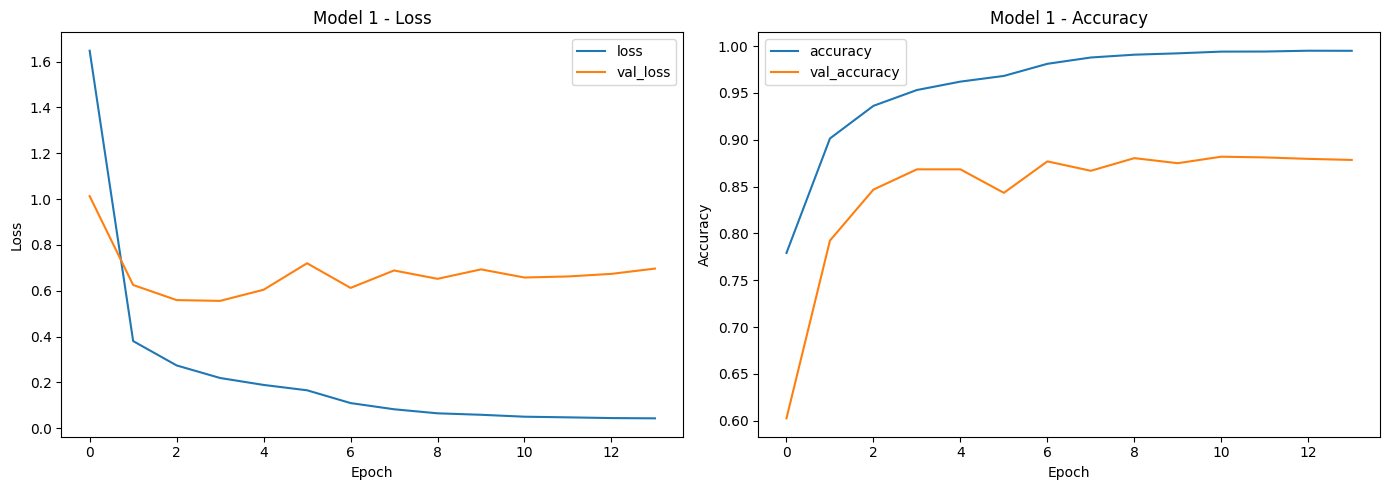

In [ ]:
history_df = pd.DataFrame(history.history)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

history_df[['loss', 'val_loss']].plot(ax=axes[0], title="Model 1 - Loss")
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

history_df[['accuracy', 'val_accuracy']].plot(ax=axes[1], title="Model 1 - Accuracy")
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


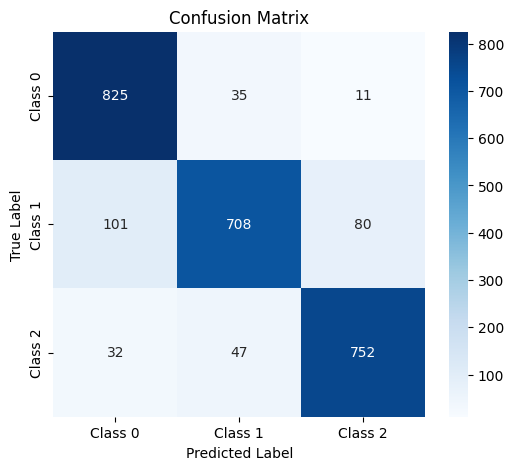

In [ ]:
# Predict probabilities
y_pred_proba = model.predict(X_val_padded)

# Convert probabilities → class indices
y_pred = np.argmax(y_pred_proba, axis=1)

# Convert one-hot encoded true labels → class indices
y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Class 0', 'Class 1', 'Class 2'],
    yticklabels=['Class 0', 'Class 1', 'Class 2']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print(classification_report(
    y_true,
    y_pred,
    target_names=['Class 0', 'Class 1', 'Class 2']
))



              precision    recall  f1-score   support

     Class 0       0.86      0.95      0.90       871
     Class 1       0.90      0.80      0.84       889
     Class 2       0.89      0.90      0.90       831

    accuracy                           0.88      2591
   macro avg       0.88      0.88      0.88      2591
weighted avg       0.88      0.88      0.88      2591



In [ ]:
test_loss, test_acc = model.evaluate(X_val_padded, Y_val)
print(f"Validation Accuracy: {test_acc:.2f}")

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8854 - loss: 0.6455
Validation Accuracy: 0.88


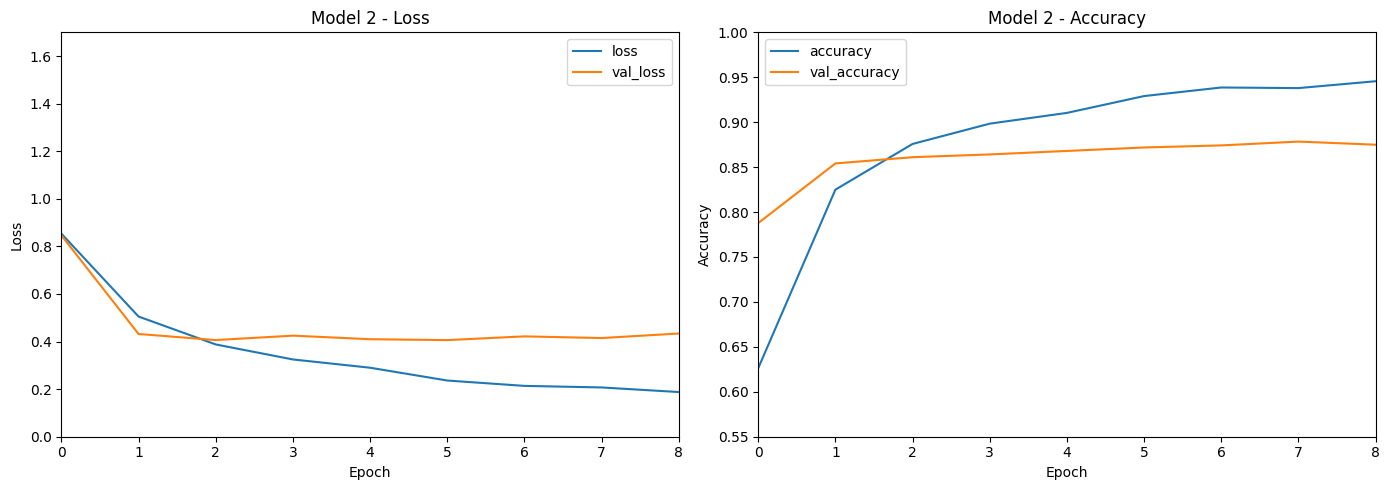

In [ ]:
history2_df = pd.DataFrame(history_2.history)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

history2_df[['loss', 'val_loss']].plot(ax=axes[0], title="Model 2 - Loss")
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_xlim(0, 8)
axes[0].set_ylim(0, 1.7)

history2_df[['accuracy', 'val_accuracy']].plot(ax=axes[1], title="Model 2 - Accuracy")
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlim(0, 8)
axes[1].set_ylim(0.55, 1.0)

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = model_2.evaluate(X_val_padded, Y_val)
print(f"Validation Accuracy: {test_acc:.2f}")

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8661 - loss: 0.4070
Validation Accuracy: 0.87


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


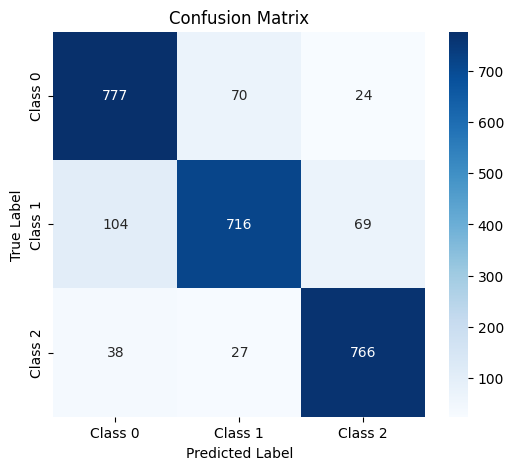

In [ ]:
# Predict probabilities
y_pred_proba = model_2.predict(X_val_padded)

# Convert probabilities → class indices
y_pred = np.argmax(y_pred_proba, axis=1)

# Convert one-hot encoded true labels → class indices
y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Class 0', 'Class 1', 'Class 2'],
    yticklabels=['Class 0', 'Class 1', 'Class 2']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print(classification_report(
    y_true,
    y_pred,
    target_names=['Class 0', 'Class 1', 'Class 2']
))

              precision    recall  f1-score   support

     Class 0       0.85      0.89      0.87       871
     Class 1       0.88      0.81      0.84       889
     Class 2       0.89      0.92      0.91       831

    accuracy                           0.87      2591
   macro avg       0.87      0.87      0.87      2591
weighted avg       0.87      0.87      0.87      2591



## Model Comparison: Key Insights

### Training Behavior Analysis

| Aspect | Model 1 | Model 2 | Winner |
|--------|---------|---------|--------|
| **Epochs Trained** | 15 (early stopped) | 8 (early stopped) | Model 2 (converged faster) |
| **Final Training Loss** | ~0.04 | ~0.20 | Model 2 (more stable) |
| **Final Validation Loss** | ~0.58 | ~0.40 | Model 2  |
| **Gap (Train vs Val Loss)** | Large (~0.54 gap) | Smaller (~0.20 gap) | Model 2  |
| **Overfitting** | Significant | Well-controlled | Model 2  |

### Overfitting Analysis

**Model 1 (High Capacity):**
- Training accuracy reaches ~99.5% while validation stays at 88%
- Large gap between training and validation curves indicates **overfitting**
- The model memorized training data rather than learning generalizable patterns
- Learning rate reduced 4 times (0.001 → 0.0000625) trying to improve

**Model 2 (Heavy Regularization):**
- Training accuracy ~94% with validation at 87%
- Smaller gap indicates **better generalization**
- Regularization (L1+L2, Dropout 0.5) successfully prevented overfitting
- Converged in only 8 epochs vs 15 for Model 1

### Why Model 2 Generalizes Better

1. **Fewer LSTM units (8 vs 16):** Less capacity to memorize noise
2. **Smaller Dense layer (32 vs 512):** Bottleneck forces learning essential features
3. **Higher Dropout (0.5 vs 0.3):** More aggressive regularization during training
4. **Combined L1+L2 regularization:** Penalizes both large and sparse weights

### Classification Performance Comparison

| Metric | Model 1 | Model 2 |
|--------|---------|---------|
| **Overall Accuracy** | 88% | 87% |
| **Validation Loss** | 0.63 | 0.40 |


### Key Observations

- **Model 1** achieves slightly higher accuracy (88% vs 87%) but with **severe overfitting**
- **Model 2** has **40% lower validation loss** (0.40 vs 0.63), indicating more confident predictions
- Model 1 excels at detecting Hate Speech (recall 0.95) but at the cost of generalization
- Model 2 is more **balanced** across all classes

### Final Recommendation

**Model 2 is preferred** for deployment because:
-  **40% lower validation loss** (0.40 vs 0.63) → more confident predictions
-  **Less overfitting** → more reliable on unseen data
-  **Faster convergence** (8 epochs vs 15) → more efficient training
-  **Smaller model size** → faster inference
